In [1]:
########################################################################

import cv2
# import the necessary packages
from scipy.spatial import distance as dist
from imutils import perspective
from imutils import contours
import numpy as np
import argparse
import imutils
import cv2

from IPython.display import display, Image
from easydict import EasyDict
 
## construct the argument parse and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-i", "--image", required=False, help="path to the input image")
#ap.add_argument("-w", "--width", type=float, required=False, help="width of the left-most object in the image (in inches)")
## Do args = vars(ap.parse_args() in Jupyter
#args = EasyDict({
#    "image": 10,
#    "width": 10
#})

########################################################################

In [2]:
### DECLARE GENERAL FUNCTIONS
def midpoint(ptA, ptB):
    return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

In [231]:
def measureImg(imgname, fineTuning, edgeType, minObjArea):
    #TUNE fineTuning TO MATCH THE REFERENCE OBJECT

    ### IMAGE PRE-PROCESSING
    # show image
    #print()
    #print('Original:')
    #imgname='./img/example_01.png'
    #display(Image(filename=imgname))

    # load the image
    img = cv2.imread(imgname)

    # Convert to grayscale
    img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Show and save image
    #print()
    #print('Grayscale:')
    imgname='./img_out.png'
    cv2.imwrite(imgname,img_grey)
    #display(Image(filename=imgname))

    # define a threshold, 128 is the middle of black and white in grey scale
    thresh = 256/2

    # assign blue channel to zeros
    img_binary = cv2.threshold(img_grey, thresh, 256, cv2.THRESH_BINARY)[1]

    # Show and save image
    #print()
    #print('Binary:')
    imgname='./img_out.png'
    cv2.imwrite(imgname,img_binary)
    #display(Image(filename=imgname))

    # Inverting the colors
    img_invert = abs(255 - img_binary)

    # Show and save image
    #print()
    #print('Inverted:')
    imgname='./img_out.png'
    cv2.imwrite(imgname,img_invert)
    #display(Image(filename=imgname))

    ### IMAGE PROCESSING
    # perform edge detection, then perform a dilation + erosion to
    # close gaps in between object edges
    edged = cv2.Canny(img_grey, 50, 100)

    # Show and save image
    #print()
    #print('Canny:')
    imgname='./img_out.png'
    cv2.imwrite(imgname,edged)
    #display(Image(filename=imgname))

    dilated = cv2.dilate(edged, None, iterations=1)

    # Show and save image
    #print()
    #print('Dilated:')
    imgname='./img_out.png'
    cv2.imwrite(imgname,dilated)
    #display(Image(filename=imgname))

    eroded = cv2.erode(dilated, None, iterations=1)

    # Show and save image
    #print()
    #print('Eroded:')
    imgname='./img_out.png'
    cv2.imwrite(imgname,eroded)
    #display(Image(filename=imgname))

    if edgeType == "dilated":
        edged = dilated
    elif edgeType == "eroded":
        edged = eroded
    
    ### GET IMAGE MEASUREMENTS
    # find contours in the edge map
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    # sort the contours from left-to-right and initialize the
    # 'pixels per metric' calibration variable
    (cnts, _) = contours.sort_contours(cnts)
    pixelsPerMetric = None

    # loop over the contours individually
    i = 0
    for c in cnts:
        # if the contour is not sufficiently large, ignore it
        if cv2.contourArea(c) < minObjArea:
            continue

        # compute the rotated bounding box of the contour
        orig = img.copy()
        box = cv2.minAreaRect(c)
        box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
        box = np.array(box, dtype="int")

        # order the points in the contour such that they appear
        # in top-left, top-right, bottom-right, and bottom-left
        # order, then draw the outline of the rotated bounding
        # box
        box = perspective.order_points(box)
        cv2.drawContours(orig, [box.astype("int")], -1, (0, 255, 0), 1)

        # loop over the original points and draw them
        for (x, y) in box:
            cv2.circle(orig, (int(x), int(y)), 2, (0, 0, 255), -1)

        # unpack the ordered bounding box, then compute the midpoint
        # between the top-left and top-right coordinates, followed by
        # the midpoint between bottom-left and bottom-right coordinates
        (tl, tr, br, bl) = box
        (tltrX, tltrY) = midpoint(tl, tr)
        (blbrX, blbrY) = midpoint(bl, br)

        # compute the midpoint between the top-left and top-right points,
        # followed by the midpoint between the top-righ and bottom-right
        (tlblX, tlblY) = midpoint(tl, bl)
        (trbrX, trbrY) = midpoint(tr, br)

        # draw the midpoints on the image
        cv2.circle(orig, (int(tltrX), int(tltrY)), 2, (255, 0, 0), -1)
        cv2.circle(orig, (int(blbrX), int(blbrY)), 2, (255, 0, 0), -1)
        cv2.circle(orig, (int(tlblX), int(tlblY)), 2, (255, 0, 0), -1)
        cv2.circle(orig, (int(trbrX), int(trbrY)), 2, (255, 0, 0), -1)

        # draw lines between the midpoints
        cv2.line(orig, (int(tltrX), int(tltrY)), (int(blbrX), int(blbrY)), (255, 0, 255), 1)
        cv2.line(orig, (int(tlblX), int(tlblY)), (int(trbrX), int(trbrY)), (255, 0, 255), 1)

        # compute the Euclidean distance between the midpoints
        dA = dist.euclidean((tltrX, tltrY), (blbrX, blbrY))
        dB = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))

        # if the pixels per metric has not been initialized, then
        # compute it as the ratio of pixels to supplied metric
        # (in this case, inches)
        if pixelsPerMetric is None:
            pixelsPerMetric = dB / fineTuning

        # compute the size of the object
        dimA = dA / pixelsPerMetric
        dimB = dB / pixelsPerMetric

        # convert inches to nm
        dimA = dimA*25400000
        dimB = dimB*25400000
        
        # draw the object sizes on the image
        txtcolor=(255, 171, 0)
        cv2.putText(orig, "{:.2f}nm".format(dimB),
                    (int(tltrX - 15), int(tltrY - 10)), cv2.FONT_HERSHEY_SIMPLEX,
                    0.6, txtcolor, 2, 5)
        cv2.putText(orig, "{:.2f}nm".format(dimA),
                    (int(trbrX + 10), int(trbrY)), cv2.FONT_HERSHEY_SIMPLEX,
                    0.6, txtcolor, 2)

        # Show and save output image
        print()
        print('Measurements in progress ... ' + str(i))
        print('dimX=' + str(round(dimB,2)) + 'nm;  dimY=' + str(round(dimA,2)) + 'nm;')
        imgname='./img/F4a_Lei2015_out.png'
        cv2.imwrite(imgname,orig)
        display(Image(filename=imgname))
        i += 1


Measurements in progress ... 0
dimX=24257000.0nm;  dimY=23918557.99nm;


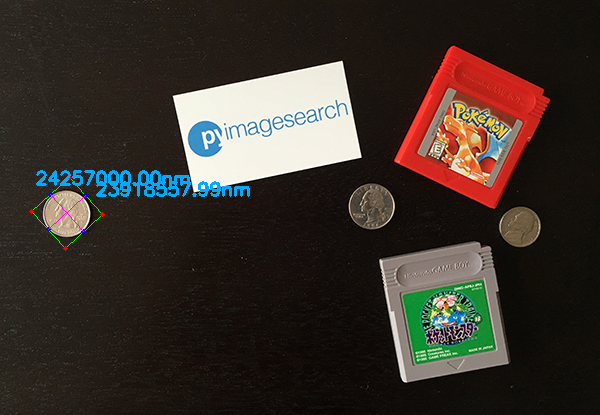


Measurements in progress ... 1
dimX=83409133.14nm;  dimY=47979120.41nm;


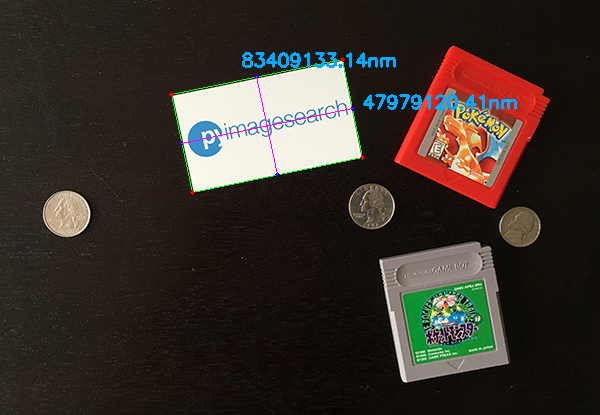


Measurements in progress ... 2
dimX=22043683.61nm;  dimY=22043683.61nm;


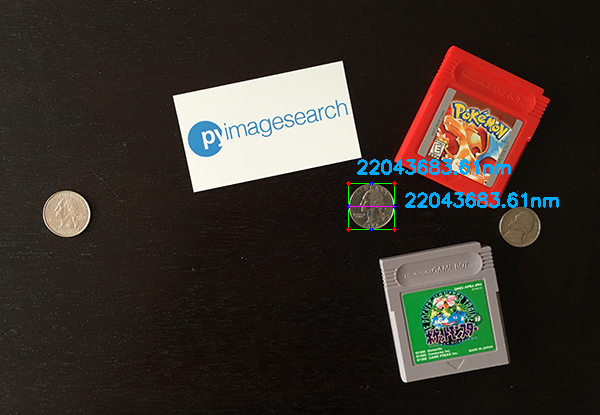


Measurements in progress ... 3
dimX=54606873.81nm;  dimY=60906883.3nm;


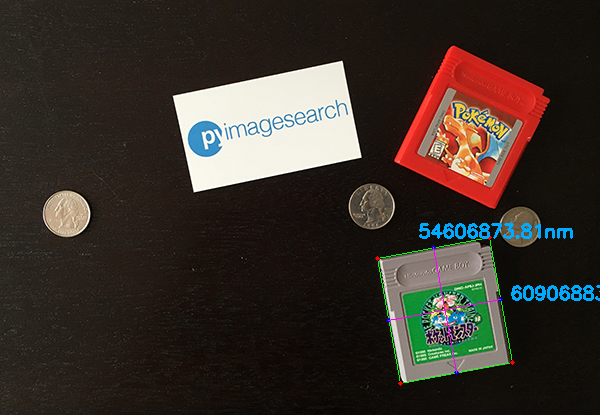


Measurements in progress ... 4
dimX=56154087.51nm;  dimY=63334246.11nm;


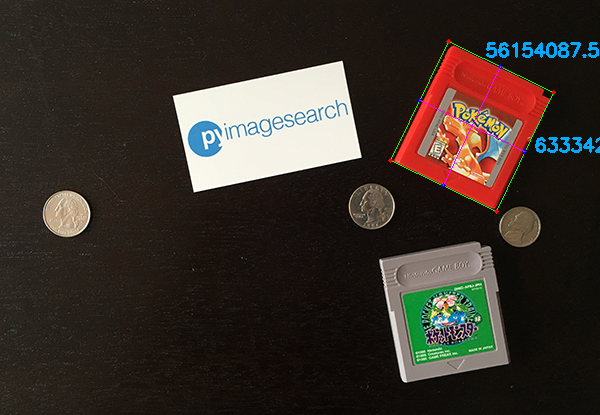


Measurements in progress ... 5
dimX=19647631.04nm;  dimY=19168420.53nm;


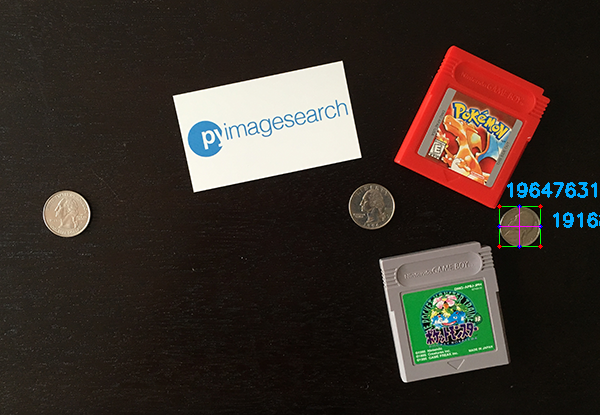

In [232]:
measureImg('./img/example_01.png', 0.955, 'eroded', 100)


Measurements in progress ... 0
dimX=420634.92nm;  dimY=444444.45nm;


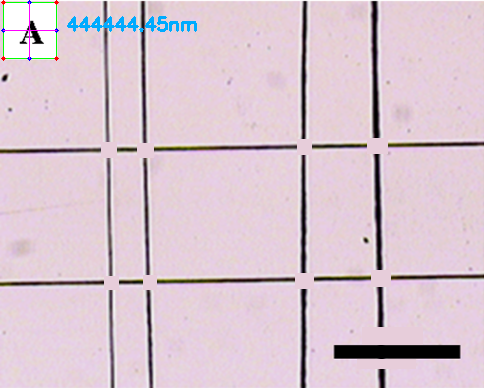


Measurements in progress ... 1
dimX=36585.49nm;  dimY=1111288.25nm;


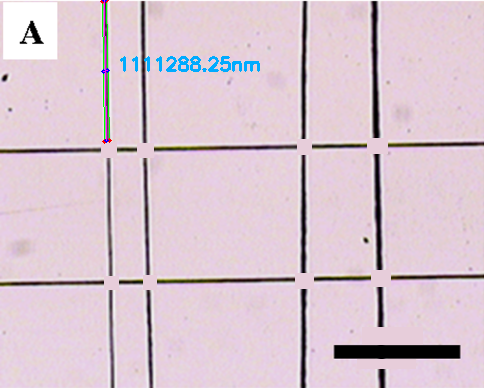


Measurements in progress ... 2
dimX=36585.49nm;  dimY=928783.39nm;


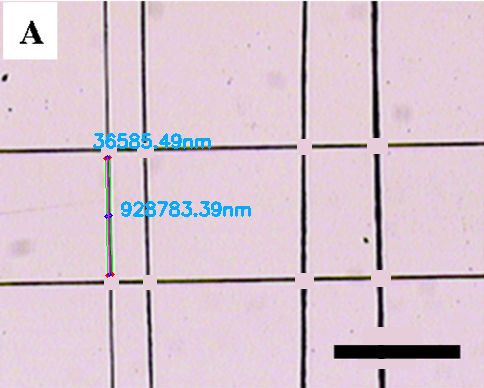


Measurements in progress ... 3
dimX=40468.41nm;  dimY=1119160.19nm;


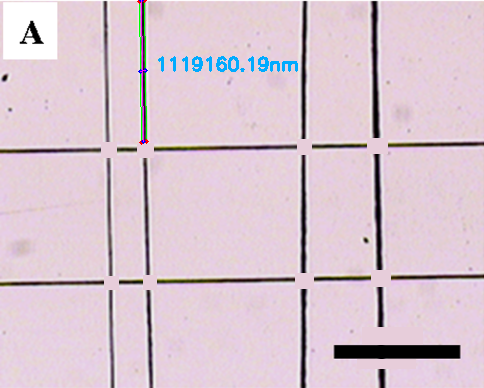


Measurements in progress ... 4
dimX=32723.06nm;  dimY=920942.75nm;


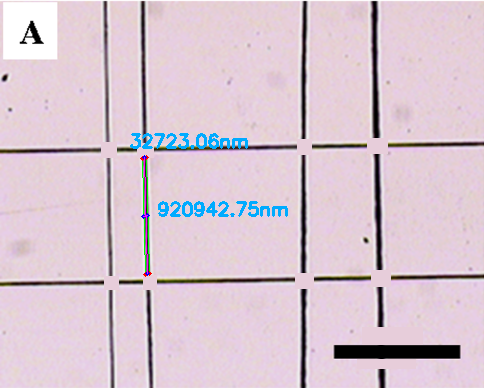


Measurements in progress ... 5
dimX=1131126.42nm;  dimY=35934.07nm;


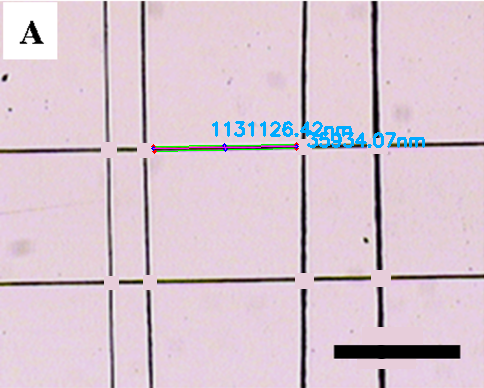


Measurements in progress ... 6
dimX=1095417.81nm;  dimY=36585.49nm;


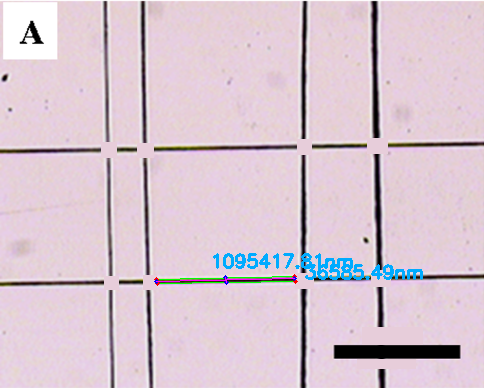


Measurements in progress ... 7
dimX=39682.54nm;  dimY=928571.43nm;


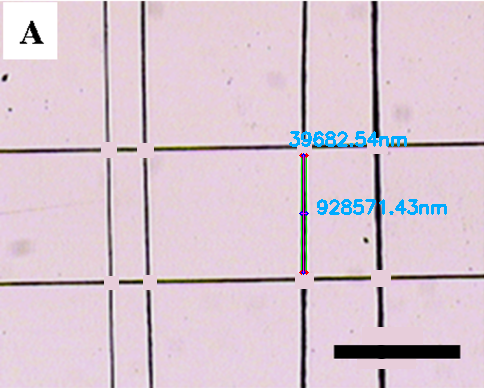


Measurements in progress ... 8
dimX=48275.89nm;  dimY=1087417.45nm;


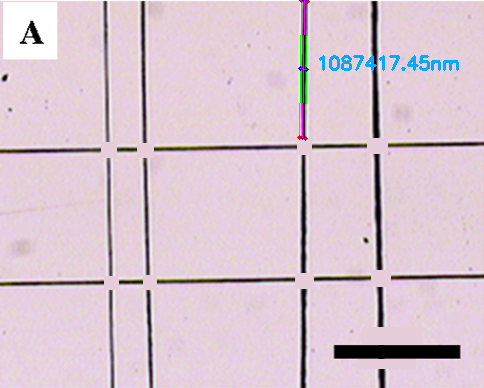


Measurements in progress ... 9
dimX=1000000.0nm;  dimY=103174.6nm;


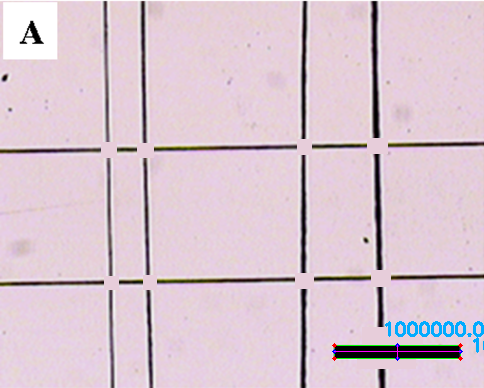


Measurements in progress ... 10
dimX=55697.1nm;  dimY=1083449.62nm;


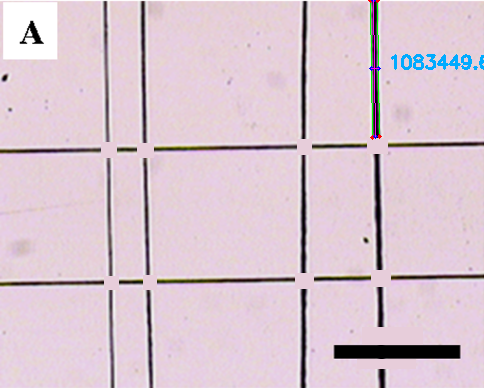


Measurements in progress ... 11
dimX=60050.58nm;  dimY=912914.06nm;


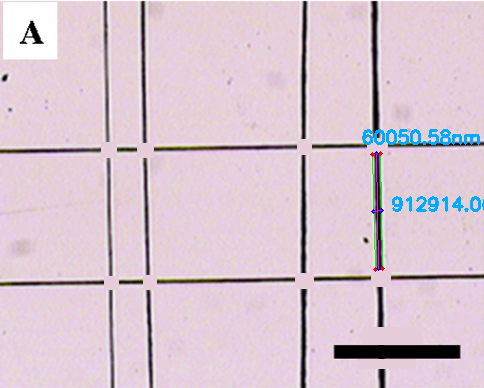

In [247]:
measureImg('./img/F4a_Lei2015.png', 0.01656043, 'canny', 250)


Measurements in progress ... 0
dimX=2475605.34nm;  dimY=793333.27nm;


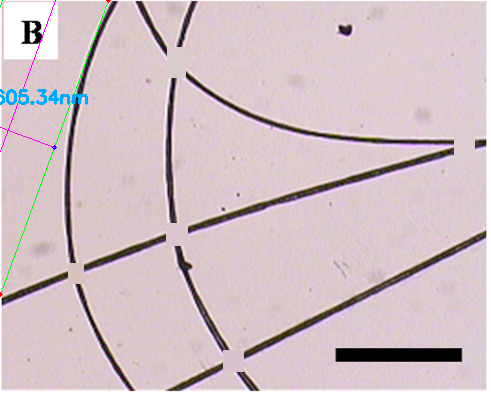


Measurements in progress ... 1
dimX=2099352.61nm;  dimY=216624.51nm;


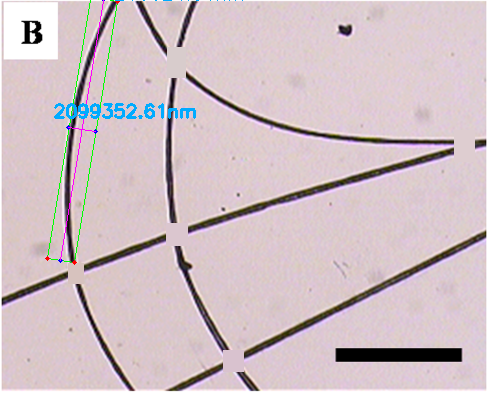


Measurements in progress ... 2
dimX=2210987.04nm;  dimY=79066.9nm;


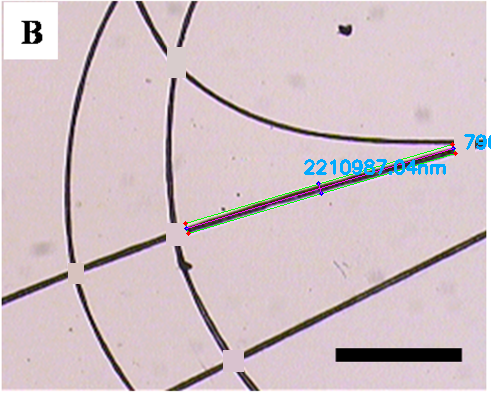


Measurements in progress ... 3
dimX=1000000.0nm;  dimY=103174.6nm;


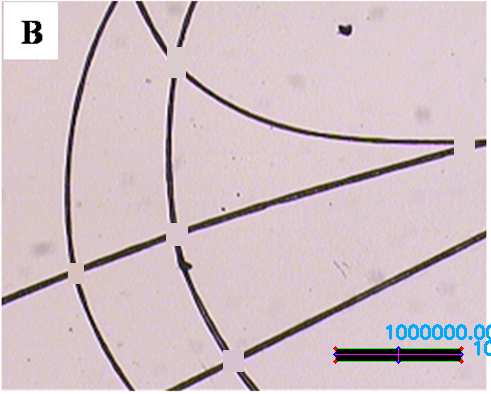

In [278]:
measureImg('./img/F4b_Lei2015.png', 0.097464777, 'canny', 1000) #50